In [208]:
import jax
import jax.numpy as jnp
import surrojax_gp
import approx_post
import oed_toolbox
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
def compute_true_log_posterior(model, noise_cov, prior_mean, prior_cov, theta_lims=(-0.5,1.5), num_int_pts=1000):
    
    noise_icov = jnp.linalg.inv(noise_cov)
    prior_icov = jnp.linalg.inv(prior_cov)

    def unnorm_posterior(theta, y, d):
        y_pred = model.predict(theta, d)
        unnorm_vals = -0.5*(jnp.einsum('ai,ij,aj->a', y-y_pred, noise_icov, y-y_pred) + \
                            jnp.einsum('ai,ij,aj->a', theta-prior_mean, prior_icov, theta-prior_mean))
        return jnp.exp(unnorm_vals)

    theta_int = jnp.linspace(*theta_lims, num_int_pts).reshape(-1,1)
    d_theta = (theta_lims[1]-theta_lims[0])/(num_int_pts-1)
    def norm_const(y, d):
        unnorm_vals = unnorm_posterior(theta_int, y, d)
        return jnp.trapz(unnorm_vals.squeeze(), dx=d_theta)

    def true_posterior(theta, y, d):
        norm_const_val = norm_const(y, d)
        unnorm_val = unnorm_posterior(theta, y, d)
        return unnorm_val/norm_const_val

    return true_posterior

In [156]:
prng = jax.random.PRNGKey(42)

Load our previously trained model from Notebook \[1\]

In [157]:
beam_gp = surrojax_gp.load_gp('nonlinear_beam_gp.json')

Let's define our prior and noise covariance:

In [158]:
noise_cov = 0.1*jnp.identity(1)
prior_cov = 0.1*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))

In [159]:
model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
true_posterior = compute_true_log_posterior(model, noise_cov, prior_mean, prior_cov)

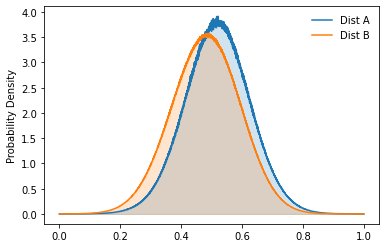

In [228]:
noise_cov = 0.01*jnp.identity(1)
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.6*jnp.ones((1,))
true_posterior = compute_true_log_posterior(model, noise_cov, prior_mean, prior_cov)
y = jnp.array([[0.5]])
d = jnp.array([[0.9]])
theta = jnp.linspace(0.0, 1.0, 5000).reshape(-1,1)
pdf_1 = true_posterior(theta, y, d)
y = jnp.array([[0.7]])
d = jnp.array([[0.23]])
pdf_2 = true_posterior(theta, y, d)
plot_distributions(jnp.stack([pdf_1, pdf_2], axis=0), theta, pdf_labels=['Dist A', 'Dist B'])

In [213]:
jnp.stack([pdf_1, pdf_2], axis=0).shape

(2, 5000)

Create Laplace approximation posterior:

In [ ]:
model = oed_toolbox.model.from_surrojax_gp(beam_gp)
minimizer = oed_toolbox.optim.gradient_descent_for_map()
laplace_approx = oed_toolbox.Distributions.Posterior.laplace_approx(model, minimizer)

Create amortised inference posterior (Normal distribution):

In [ ]:
normal_approx = approx_post.approx.Gaussian(ndim=1)
amortised_approx = approx_post.amortised.NeuralNetwork(normal_approx, x_dim=1, prngkey=prng)

joint = 

Create amortised inference posterior (Mixture distribution):

Let's see how the mean and covariance of the Laplace approximation and the amortised distribution change with the beam angle and design: